# Krok 1: Przegląd i zrozumienie danych
Dane są wczytywane i przeglądane. Opis oferty znajduje się w zmiennej 'description'
- interesują tel używane i iphone, generalnie filtrowanie
Tworzenie labeli
- sprawdzanie czy pojawiają się indykatory wersji i nadawanie flag
- tworzenie labeli
- sprawdzanie pod kątem podwójnych oznaczeń i eliminowanie szumu


In [19]:
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
# import spacy
# nlp = spacy.load('pl_core_news_sm')

In [2]:
# Notebook params

warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams.update({'font.size': 15})

In [3]:
## Task Initialisation
org_data = pd.read_csv('data.csv')
print(org_data.shape)
org_data.head(5)
# data[data.condition.isna()]

(5084, 13)


,http,voivodeship,scrap_time,name,price,brand,condition,offer_from,type,description,added_at,views,user_since
0,https://www.olx.pl/oferta/iphone-11-64-jak-now...,pomorskie,2021-02-22 06:55:30,Iphone 11 64 jak nowy 95% gwarancja wyświetlacz,2799.0,iPhone,Używane,Osoby prywatnej,Sprawny,Jak nowy . Kondycja baterii 95%. Kupiony w med...,2021-02-22 00:09:00,37,2013-05-01 00:00:00
1,https://www.olx.pl/oferta/skup-uszkodzonych-te...,pomorskie,2021-02-22 06:55:34,Skup uszkodzonych telefonów iPhone xs xs max 1...,NaN,NaN,NaN,Firmy,NaN,Witam. Kupię uszkodzone/ zablokowane/ zalane/...,2021-02-22 00:05:00,5242,2020-04-01 00:00:00
2,https://www.olx.pl/oferta/iphone-11-64-gb-czar...,pomorskie,2021-02-22 06:55:40,"IPhone 11 64 GB czarny, idealny z gwarancją. W...",2700.0,iPhone,Używane,Osoby prywatnej,Sprawny,Witam! Mam na sprzedaż iPhone’a 11 w wersji 64...,2021-02-21 19:00:00,186,2014-12-01 00:00:00
3,https://www.olx.pl/oferta/iphone-11-CID99-IDIk...,pomorskie,2021-02-22 06:55:44,Iphone 11,3000.0,iPhone,Nowe,Osoby prywatnej,Sprawny,Nowy 128GB Oryginalnie zapakowany kolor czar...,2021-02-21 18:24:00,250,2016-06-01 00:00:00
4,https://www.olx.pl/oferta/jak-nowy-apple-iphon...,pomorskie,2021-02-22 06:55:52,Jak Nowy Apple Iphone 11 256gbGB White Gwarancja,2899.0,iPhone,Używane,Firmy,Sprawny,Witaj. Jesteśmy sklepem - serwisem z 12 le...,2021-02-21 17:38:00,845,2012-08-01 00:00:00


#### EDA

In [249]:
org_data.describe()
# org_data[org_data['price']>10000]

# There are values very small in the data set (price = 100) and very big (10000), which do not make sense
# in the case of a few years old iPhones. 
# Review of these records showed these are accessories (eg phone case). They will be filtered out as the 
# focus is on iPhones only

,http,voivodeship,scrap_time,name,price,brand,condition,offer_from,type,description,added_at,views,user_since
609,https://www.olx.pl/oferta/etui-samsung-a31-a51...,dolnoslaskie,2021-01-08 00:02:17,"Etui samsung a31/a51 , iphone 11(pancer)",12345.0,NaN,Nowe,Osoby prywatnej,NaN,Etui Samsung-15 zł iPhone -30 zł Nówki sztu...,2021-01-07 12:35:00,78,2020-11-01 00:00:00


In [262]:
print('Unique rows with nulls:', org_data[org_data.isnull().any(axis=1)].count()[0])
org_data.isna().sum()

# Missing values in the dataset are present either in price, brand, condition or type fields. While there
# are around 1400 missing values, they appear only in less than 700 rows. This means that often there is more
# than one missing value per row. This is because some offers are accessories, other offers or just 
# bulk ones (they buy/sell multiple phones). Such offers need to be filtered out. 
# Some information could be extracted from description of these fields 

Unique rows with nulls: 677


http             0
voivodeship      0
scrap_time       0
name             0
price          337
brand          466
condition      131
offer_from       0
type           458
description      0
added_at         0
views            0
user_since       0
dtype: int64

In [4]:
org_data['date'] = org_data['added_at'].str[:10]
org_data = org_data.drop(columns='added_at')

In [5]:
print('Brand types:', org_data.brand.unique())
print('Condition types:', org_data.condition.unique())
print(org_data.type.unique())

# There is a lot of noise
# iPhones are marked as iPhones
# There are nulls in the brand and condition fields, but quick check showed these are bulk offers or accessories
# There are offers with new phones

data = org_data[['name', 'price', 'brand', 'condition', 'type', 'description', 'date']].copy()
data = data[data.brand == 'iPhone']
data = data[data.condition == 'Używane']
data = data[data.type == 'Sprawny']
data = data[~data.price.isna()]

Brand types: ['iPhone' nan 'Inne telefony gsm' 'Samsung' 'LG']
Condition types: ['Używane' nan 'Nowe']
['Sprawny' nan 'Uszkodzony' 'Męskie']


In [252]:
# Review of name and description fields - they have the information we are interested in: model type, storage etc 
for field in ['name', 'description']:
    for obs in data[field][:3]:
        print(obs, '\n')

Iphone 11 64 jak nowy 95% gwarancja wyświetlacz 

IPhone 11 64 GB czarny, idealny z gwarancją. Wymiana 

Jak Nowy Apple Iphone 11 256gbGB White Gwarancja 

Jak nowy . Kondycja baterii 95%. Kupiony w media markt . Posiadam faktury . Dodatkowa gwarancja na zbity wyświetlacz wartość 600zł . Dodatkowo szkło hartowane 5D oraz pokrowiec SPIGEN wartość 80zl. Nie sprzedaje za granice !! . Polecam 

Witam! Mam na sprzedaż iPhone’a 11 w wersji 64 GB. Telefon jest w stanie idealnym, wręcz jak nowym, ani jednej rysy ma przedzie l, rantach czy tyle. Posiada gwarancje do 17 września 2021 roku. Zakupiony w sieci play przez pierwszego właściciela, odkupiłem telefon jako nowy i wykonałem skany dokumentów osobiście. Zdjęć telefonu nie zamieściłem z powodu braku drugiego telefonu, jednakże wyglada on jak nowy. Założone jest szkło hartowane, lekko pęknięte chyba od kluczy w kieszeni natomiast ubrany jest w siwe etui Apple. Umieszczam screen gwarancji. Wszystkie dokumenty z pudełka i słuchawki nowe, nigdy 

#### Flagging phone models 

In [6]:
# For many NLP tasks a good approach would be to use pretrained models, use matching, types of words etc
# there are just a few types of iP11s and they are usually mentioned in name
# simpler approach:


def check_presence(text):
    ''' 
    Checking presence of a specified text in columns 'name' and 'description' of the 
    'data' pandas dataframe containing scrapped data of iPhone 11 offers.
    If text is present, returns 1. Otherwise returns 0.
    '''
    col1_check = data['name'].str.contains(text)
    col2_check = data['description'].str.contains(text)
    return col1_check.astype(int) | col2_check.astype(int)

params = ['11', '64', '128', '256', '512', '64GB', '128GB', '256GB', '512GB', 'Pro ', 'Pro Max']

for text in params:
    data[text] = check_presence(text)

data['Pro'] = data['Pro ']
data['Pro_Max'] = data['Pro Max']
data.drop(columns=['Pro ', 'Pro Max'], inplace=True)

# Because all Pro Maxes also contain "Pro" and thus received flag "Pro" as 1, changing all these instances to 0
data.loc[data['Pro_Max'] == 1, 'Pro'] = 0

def merging_flags(df):
    ''' Merging flags which mean the same, eg "64" and "64GB"'''
    df['64'] = df['64'] | df['64GB']
    df['128'] = df['128'] | df['128GB']
    df['256'] = df['256'] | df['256GB']
    df['512'] = df['512'] | df['512GB']
    df.drop(columns=['64GB', '128GB', '256GB', '512GB'], inplace=True)

merging_flags(data)

In [7]:
data[data['64']==0][data['128']==0][data['256']==0].head(2)

# There are 260 cases where the storage is not specified. These might be the base models, but not necessarily. 
# These observations could be treated as base version and added to training, then checked if their presence 
# helps the model
# For now these observations are filtered out as their 
# There is also an example of an observation which is not iPhone 11, but iPhone 7, with 11 free cases. Such noise 
# is usually hard to fully eliminate fully, but it should show up during outliers investigation 

mask = (data['64'] == 0) & (data['128'] == 0) & (data['256'] == 0)
data = data[~mask]
print(data.shape)

(2494, 14)


<ipython-input-7-55272d1fc27b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['64']==0][data['128']==0][data['256']==0].head(2)


In [8]:
### Creating labels
models = ['Pro_Max', 'Pro']
storages = ['64', '128', '256', '512']

# We want flags if both Pro and Pro Max are mentioned (noisy data), but we don't standard model to be mentioned if we 
# already know it's pro

def labels_function(df):
    for index, row in df.iterrows():    
        row_flag = 0
        for model in models:
            if row[model] == 1:
                row_flag = 1 #local flag to exit loop if that's Pro model
                for storage in storages:
                    if row[storage] == 1:
                        df.at[index, model+'_'+storage] = 1
        if row_flag == 0: 
            for storage in storages:
                if row[storage] == 1:
                    df.at[index, '11_'+storage] = 1

def melting_function(df):
    labels_function(df)
    df = df.reset_index()
    melting = pd.melt(df, 
                      id_vars = ['index','name', 'price', 'brand', 'condition', 'type', 'description', 'date'], 
                      value_vars=['11_64', '11_256', 'Pro_256', '11_128', 'Pro_64', 'Pro_128', 'Pro_512'])
    return melting[melting['value']==1]

data_lab = melting_function(data)
data_lab.head(1)


,index,name,price,brand,condition,type,description,date,variable,value
0,0,Iphone 11 64 jak nowy 95% gwarancja wyświetlacz,2799.0,iPhone,Używane,Sprawny,Jak nowy . Kondycja baterii 95%. Kupiony w med...,2021-02-22,11_64,1.0


In [9]:
# Number of observations returning multiple flags
lab_count = data_lab[data_lab['value']==1].groupby('index').count()
print(lab_count[lab_count['value']>1]['name'].count())

mask = lab_count['value']>1
multiple = [x for x in mask.loc[mask == True].index]
filtered_data = data_lab[~data_lab['index'].isin(multiple)]

# Clearing indexes
filtered_data = filtered_data.reset_index()
filtered_data = filtered_data.drop(columns=['index', 'level_0', 'value'])
filtered_data = filtered_data.rename(columns = {'variable': 'label'})

55


In [36]:
filtered_data.shape

(2348, 10)

<ipython-input-13-6f3a86b43853>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_price = filtered_data.groupby(['date', 'label']).mean()
<ipython-input-13-6f3a86b43853>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_price = filtered_data.groupby(['date', 'label']).median()


<AxesSubplot: xlabel='date'>

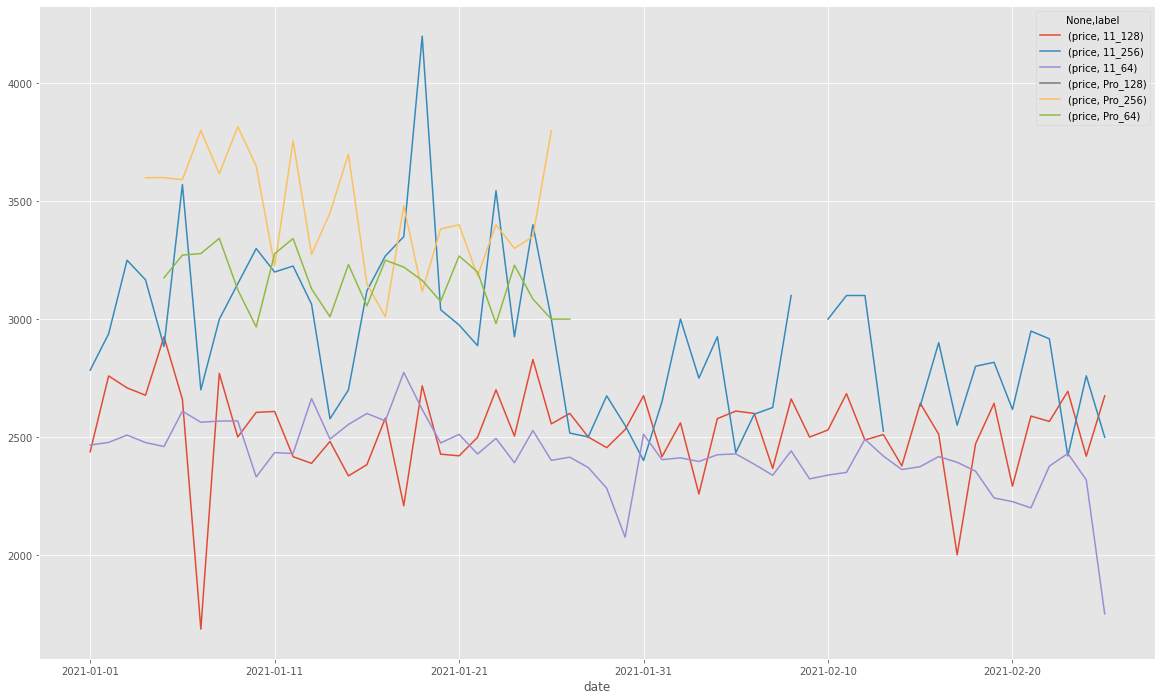

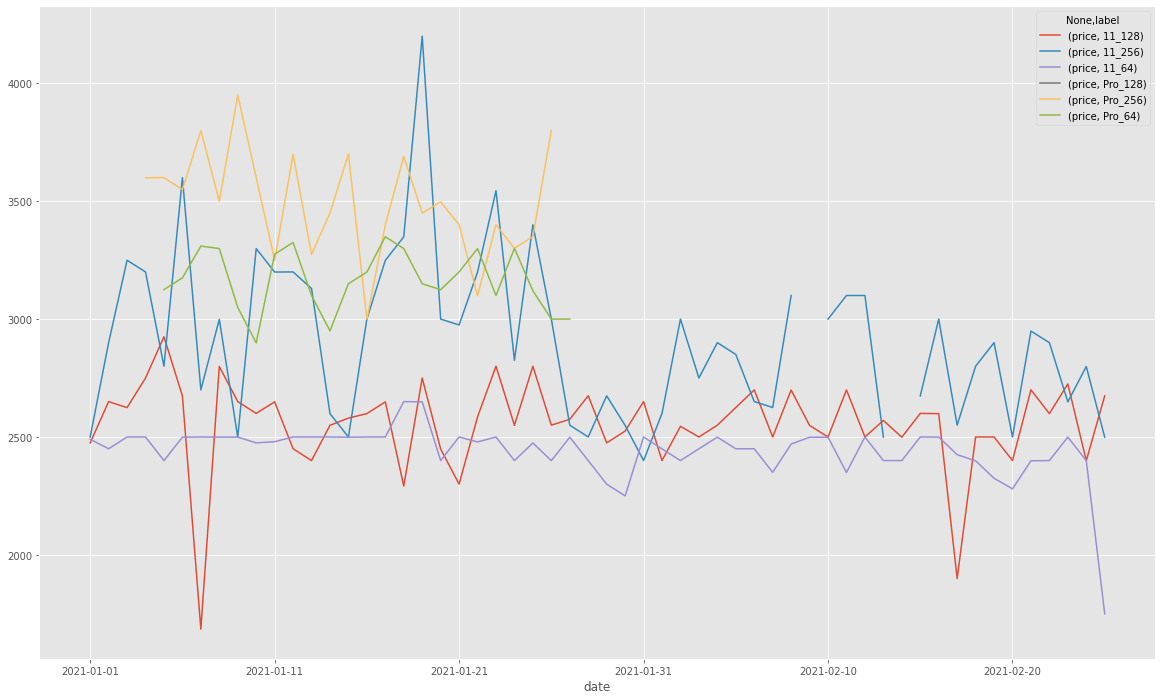

In [13]:
# Visualizing models history of average and median prices
plt.rcParams["figure.figsize"] = (20,12)

avg_price = filtered_data.groupby(['date', 'label']).mean()
avg_price.unstack().plot()

median_price = filtered_data.groupby(['date', 'label']).median()
median_price.unstack().plot()

- period of available data is quite short. While it's impossible to check yearly seasonality, there might exist some weekly or monthly ones 
- decomposition breaks down a time series into its underlying components, such as trend, seasonality, and residuals
However, with only two months of daily data, it may be difficult to accurately identify and model the trend and seasonality components, as there may not be enough data to reliably estimate these components. In such cases, the decomposition may not add much value to the forecasting process, and it may be more appropriate to focus on developing the ARIMA or SARIMA model directly.
- checked SARIMA after all

In [50]:
# For the purpose of PoC the focus is on the base iPhone 11 64 GB model
basic = filtered_data[filtered_data['label']=='11_64'].groupby(['date', 'label']).mean()
basic = basic.reset_index().drop('label', axis = 1)
basic = basic.set_index('date')
basic = basic
basic.head(2)

<ipython-input-50-f38c3c149a32>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  basic = filtered_data[filtered_data['label']=='11_64'].groupby(['date', 'label']).mean()


,price
date,
2021-01-01,2465.619048
2021-01-02,2477.090909


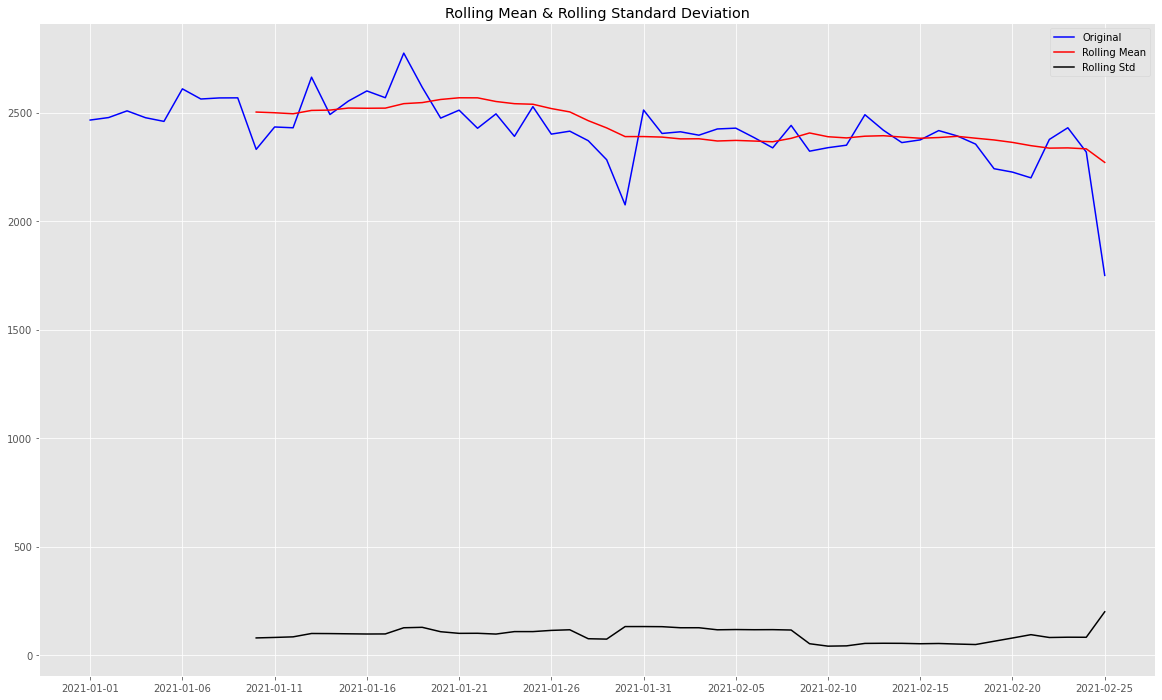

In [15]:
# Checking if data is stationary

rolling_mean = basic.rolling(window = 10).mean()
rolling_std = basic.rolling(window = 10).std()

# Ticks adjustment
ticks_all = basic.index.tolist()
ticks = ticks_all[0::5]

fig, ax = plt.subplots()
plt.plot(basic, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
ax.set_xticks(ticks)
plt.show()

In [51]:
warnings.filterwarnings("ignore")

model_data = basic#**3
model_data.index = pd.DatetimeIndex(model_data.index)

## Finding parameters for time series model
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
AIC_estimates = []
params1 = []
params2 = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(model_data['price'],order=param,seasonal_order=param_seasonal,enforce_stationarity=True,enforce_invertibility=False)
            results = mod.fit()
            # print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            params1.append(param)
            params2.append(param_seasonal)
            AIC_estimates.append(results.aic)
        except: 
            continue

print('Tested {} possibilities'.format(len(AIC_estimates)))
print('The lowest estimate for AIC is ', min(AIC_estimates))
print('Parameters with the lowest AIC {} {}'.format(
    params1[AIC_estimates.index(min(AIC_estimates))], 
    params2[AIC_estimates.index(min(AIC_estimates))]))
warnings.resetwarnings()

Tested 64 possibilities
The lowest estimate for AIC is  564.7900684103763
Parameters with the lowest AIC (1, 1, 1) (1, 1, 0, 12)


In [52]:
# Training
# Model is trained on 41 days (75%), thus 14 (25%) are left for performance testing 
warnings.filterwarnings("ignore")
mod = sm.tsa.statespace.SARIMAX(model_data['price'][:41],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
warnings.resetwarnings()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1984      0.588      0.338      0.736      -0.953       1.350
ma.L1         -0.6957      0.404     -1.724      0.085      -1.487       0.095
ar.S.L12      -0.3573      0.447     -0.798      0.425      -1.234       0.520
sigma2      1.912e+04   5247.164      3.645      0.000    8840.030    2.94e+04


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot: xlabel='date'>

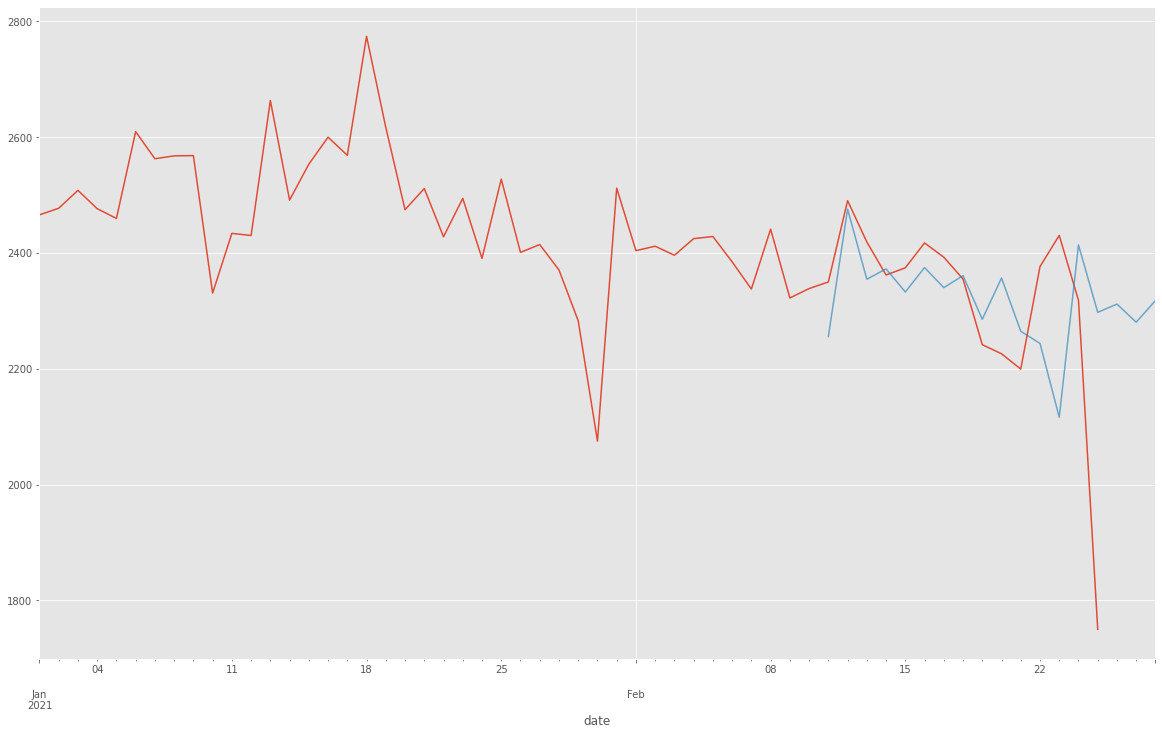

In [53]:
pred = results.get_prediction(start=pd.to_datetime('2021-02-11'), end=pd.to_datetime('2021-02-28'))

ax = model_data['price'].plot(label='Real')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

In [54]:
df_forecasted = pred.predicted_mean
df_truth = model_data['price']
mse = ((df_forecasted - df_truth) ** 2).mean()
print('The Mean Squared Error: {}'.format(round(mse, 2)))
print('The Root Mean Squared Error: {}'.format(round(np.sqrt(mse), 2)))

# The data was transformed to the power of 3 and to understand the real error in PLN, the 
# score needs to be transformed back
# print('The real RMSE in PLN: {}'.format(round(np.sqrt(mse)**(1/3))))

# As seen on the chart with results, in the first half the model performs much better,
# while in the second half of testing there is a strange price-drop. It makes sense to 
# see how the model performs not only in overall, but also in the "normal" period

# rmse_half = np.sqrt((((pred.predicted_mean[:7]-model_data['price'])**2).mean()))**(1/3)
# rmse_half2 = np.sqrt((((pred.predicted_mean[7:]-model_data['price'])**2).mean()))**(1/3)
# print('\nRMSE in PLN on the first half of test: {}'.format(round(rmse_half)))
# print('RMSE in PLN on the second half of test: {}'.format(round(rmse_half2)))

# Score is two times better in the first half of testing period

The Mean Squared Error: 31190.04
The Root Mean Squared Error: 176.61
The average 


In [ ]:
Suggestions: